In [70]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge

from eli5 import explain_weights

from sklearn import preprocessing
from sklearn import linear_model 

from helpers.features import fix_predicted_price, confidence_interval

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

plt.rcParams['figure.figsize']=(16,6)

## Help functions

In [58]:
def mean_absolute_percentage_error(reg, X, y): 
    return np.mean(np.abs((y - reg.predict(X)) / y)) * 100

In [59]:
def evaluate_model(reg, data, features, cv=5, transform_method=None, plot=False):

    if transform_method:
        data = pd.concat([pd.DataFrame(transform_method.fit_transform(data[(features)]), index=data[features].index, columns=features),
                          data['price_usa']], axis=1)

    if plot:
        X_train, X_test, y_train, y_test = train_test_split(data[features], data['price_usa'], test_size=0.33, random_state=42)
        reg.fit(X_train, y_train)
        predictions = reg.predict(X_test)
        predictions_sorted = reg.predict(X_test.loc[y_test.sort_values().index.values])
        
        print("Mean Absolute Error: {:.4f}".format(mean_absolute_error(y_test, predictions)))
        print("Mean absolute percentage error: {:.4f}".format(mean_absolute_percentage_error(reg, X_test, y_test)))
        print()
        print("Mean Squared Error: {:.4f}".format(mean_squared_error(y_test, predictions)))
        print("R2 score: {:.4f}\n".format(r2_score(y_test, predictions)))
    
        plt.plot(sorted(y_test), c='r')
        plt.scatter(range(len(y_test)), predictions_sorted, s=1.7)
        plt.xlabel('sorted index')
        plt.ylabel('price usa')
        plt.grid()
        
        return reg

    # MAE
    cross_scores = cross_val_score(reg, data[features], data['price_usa'], scoring='neg_mean_absolute_error', cv=cv)
    print("Mean (MAE) CV {}-fold: {:.4f}".format(cv, -np.mean(cross_scores)))
    
    # MAPE
    cross_scores = cross_val_score(reg, data[features], data['price_usa'], scoring=mean_absolute_percentage_error, cv=cv)
    print("Mean (MAPE) CV {}-fold: {:.4f}".format(cv, np.mean(cross_scores)))
    
    # MSE
    cross_scores = cross_val_score(reg, data[features], data['price_usa'], scoring='neg_mean_squared_error', cv=cv)
    print("Mean (MSE) CV {}-fold: {:.4f}".format(cv, -np.mean(cross_scores)))
    
    # R2
    cv = StratifiedKFold(cv, random_state=42)
    cross_scores = cross_val_score(reg, data[features], data['price_usa'], scoring='r2', cv=cv)
    print("Mean (R2) CV {}-fold: {:.4f}".format(cv.get_n_splits(), np.mean(cross_scores)))

## Data

In [60]:
data = pd.read_csv('./data/cleared_data/data-example.csv')

## Feature engineering

In [61]:
plan_union = {'брежневка': 'standard_plan',
              'стандартный проект': 'standard_plan',
              'хрущевка': 'standard_plan',
              'чешский проект': 'standard_plan',
              'сталинка': 'сталинка',
              'новостройка': 'excellent_plan',
              'улучшенный проект': 'excellent_plan',
              'Пропуск': 'Пропуск_план',
              }

data['plan_proc'] = data['Планировка'].map(plan_union)

In [62]:
dum_tech = data['Бытовая техника'].str.get_dummies(sep=', ')
dum_dop = data['Дополнительно'].str.get_dummies(sep=', ')

elite_features = ['VIP-квартира',
                  'элитная квартира',
                  'консьержка',
                  'видеодомофон',
                  'сигнализация',
                  'посудомоечная машина',
                  'домашний кинотеатр',
                  'душевая кабина',
                  'джакузи',
                  'подземный гараж',
                  'охраняемая территория']

# Elite rate(value is a sum of presented features)
data['elite'] = pd.concat([dum_tech, dum_dop], axis=1)[elite_features]\
                .sum(axis=1)

## Models

In [63]:
features = [
            'floor',
            'photos_proc',
            'views_day',
            'views_week',
            'Агентство',
            'Балкон',
            'Мебель',
            'Плита',
            'Сан/узел',
            'Телефон',
            'До метро',
            'rooms',
            'living_area',
            'kitchen_area',
            'total_area',
            'До центра',
            'elite',
            'Ремонт',
            'floors',
            'Год постройки'
           ]

dum_tech = data['Бытовая техника'].str.get_dummies(sep=', ')
dum_plan = pd.get_dummies(data['plan_proc'])
dum_type = pd.get_dummies(data['Тип дома'])

data = pd.concat([data, dum_plan, dum_tech], axis=1)

features_total = features \
             + dum_plan.columns.values.tolist() \
             + dum_tech.columns.values.tolist()

In [64]:
base_transformer = StandardScaler()

In [65]:
scaled_data = pd.concat([pd.DataFrame(base_transformer.fit_transform(data[(features_total)]), 
                                      index=data[features_total].index, 
                                      columns=features_total),
                          data['price_usa']], axis=1)

parameters = {
    'alpha': np.arange(0, 100, 0.5),
}

estimator = GridSearchCV(Lasso(), parameters, scoring='mean_absolute_error')\
    .fit(scaled_data[features_total], data['price_usa'])

lasso_model = estimator.best_estimator_

Mean Absolute Error: 142.7381
Mean absolute percentage error: 26.2855

Mean Squared Error: 54573.3623
R2 score: 0.6773



Lasso(alpha=9.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

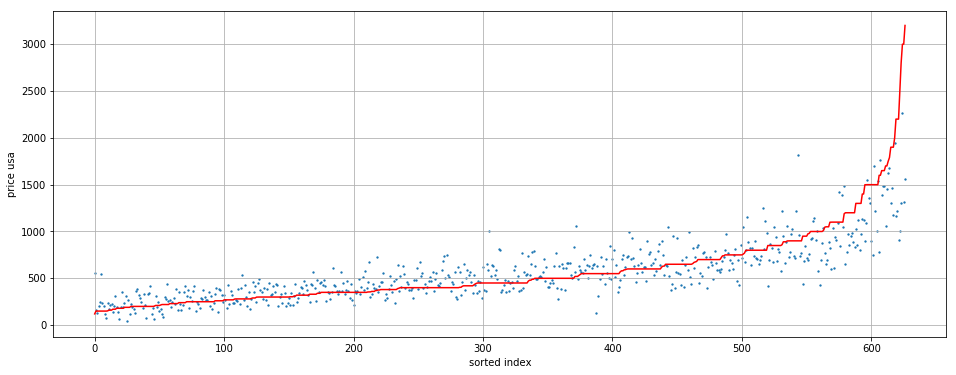

In [66]:
evaluate_model(lasso_model, data, features_total, transform_method=base_transformer, plot=True)

In [67]:
core_features = list(map(lambda x:x[0], list(filter(lambda bunch:bunch[1]!=0, zip(data[features_total].columns.tolist(), lasso_model.coef_)))))

In [68]:
parameters = {
    'alpha': np.arange(0, 100, 0.5)
}

estimator = GridSearchCV(Ridge(), 
                        parameters, scoring='mean_absolute_error').fit(data[core_features], data['price_usa'])

ridge_model = estimator.best_estimator_

Mean Absolute Error: 144.6652
Mean absolute percentage error: 27.0285

Mean Squared Error: 54674.2510
R2 score: 0.6767



Ridge(alpha=99.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

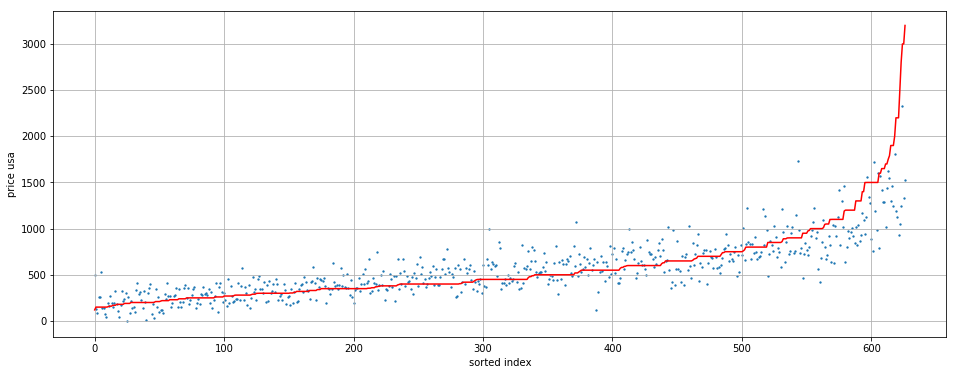

In [69]:
evaluate_model(ridge_model, data, core_features, transform_method=base_transformer, plot=True)

In [71]:
explain_weights(ridge_model, feature_names=core_features)

Weight?,Feature
+565.223,<BIAS>
+159.113,total_area
+62.630,living_area
+43.262,photos_proc
+42.414,elite
+42.353,кондиционер
+25.352,выделенная линия в интернет
+21.410,Пропуск_план
+17.772,Ремонт
+16.095,телевизор


In [72]:
data['predicted_price'] = pd.DataFrame(ridge_model.predict(base_transformer.fit_transform(data[core_features])),data.index)

In [73]:
confidence_interval(data['price_usa'], data['predicted_price'])

(-6.859250663654251, 13.444066729478429)

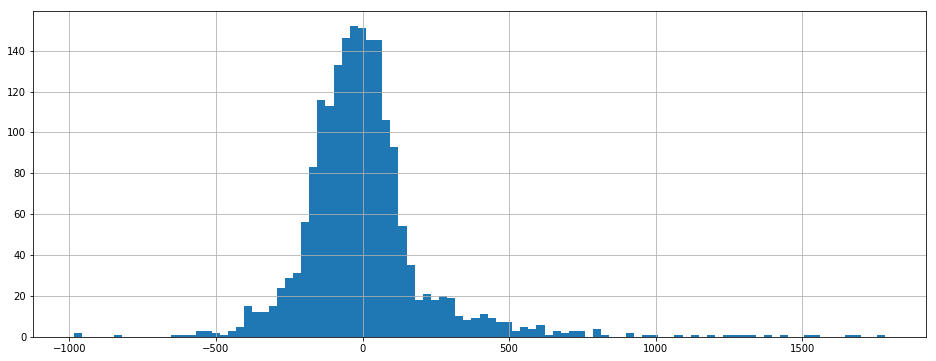

In [75]:
reg_error = (data['price_usa'] - data['predicted_price'])
reg_error.hist(bins=100)

## Fix negative or too small price by k-Neighbors

In [76]:
data = fix_predicted_price(data, core_features, 'predicted_price', 100)

In [81]:
data['predicted_price'].to_csv('./data/predicts/predict_example.csv', 
                               index=False)